# Introduction to Principal Components Analysis (PCA)

---

__Elliott Forney - 2020__

Simple example of PCA on a contrived 2D problem and on the MNIST hand-written digit data.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8.5]

## Simple 2D Example

Start with some simple 2D data, normally distributed points with covariance matrix defined below.

In [2]:
# covariance matrix
cov_2d = [[ 1.0, -0.9],
          [-0.9,  1.0]]

#cov_2d = [[3.1, 0.0],
#          [0.0, 0.35]]

# sample 2d data
data_2d = np.random.multivariate_normal((-1.4, 0.6), cov_2d, 1650)
data_2d.shape

(1650, 2)

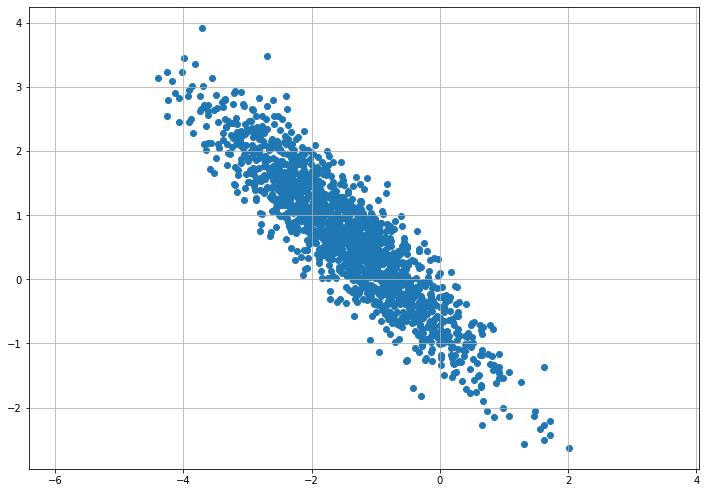

In [3]:
plt.scatter(*data_2d.T);
plt.grid();
plt.axis('equal');

Subtract out the mean.  We will want to perform rotations about the mean, so best to place it at the origin.

In [4]:
means_2d = data_2d.mean(0)
data_2d_zm = data_2d - means_2d

Singular value decomposition yields:

$\textbf{U} \in \mathbb{R}^{M, N}$ -- left singular vectors

$\textbf{d} \in \mathbb{R}^{N}$ -- singular values

$\textbf{V} \in \mathbb{R}^{N, N}$ -- right singular vectors

$\textbf{d}$ and $\textbf{V}$ can be thought of as rotation and scale operations and $\textbf{U}$ the reverse operation.  This rotation provides a change of basis where the first dimension is that which captures, i.e., when projected upon, the most variance in the data.  The second dimension captures the second most variance, subject to the constraint that it is orthogonal to the first.  et cetra. 

In [5]:
u, d, v = np.linalg.svd(data_2d_zm, full_matrices=False)
u.shape, d.shape, v.shape

((1650, 2), (2,), (2, 2))

In [6]:
u

array([[-0.0048, -0.0173],
       [ 0.0181, -0.005 ],
       [ 0.0232,  0.0235],
       [ 0.0208,  0.018 ],
       ...,
       [-0.0026, -0.0184],
       [ 0.0525, -0.0061],
       [-0.0173,  0.047 ],
       [ 0.061 , -0.0313]])

In [7]:
d

array([56.8926, 12.6719])

In [8]:
v

array([[ 0.7109, -0.7033],
       [ 0.7033,  0.7109]])

Note that the rows of $\mathbf{V}$ are normal, i.e., unit length.  These vectors provides our new basis.

In [9]:
np.sqrt(np.sum(v**2, axis=0))

array([1., 1.])

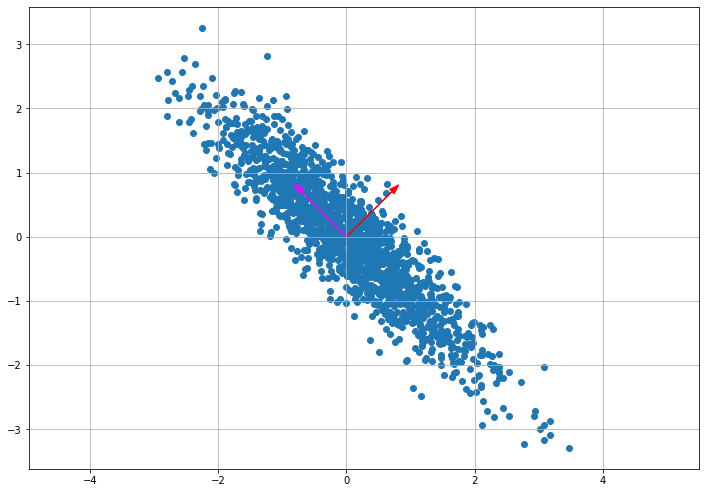

In [10]:
plt.scatter(*data_2d_zm.T);
plt.arrow(0, 0, *v[:, 0], head_width=0.1, color='red');
plt.arrow(0, 0, *v[:, 1], head_width=0.1, color='magenta');
plt.grid();
plt.axis('equal');

Alternately, this can be thought of as a rotation.  Note that the data is now rotated so that the x axis captures the most variance and the y axis captures the second most and is orthogonal to the first axis.

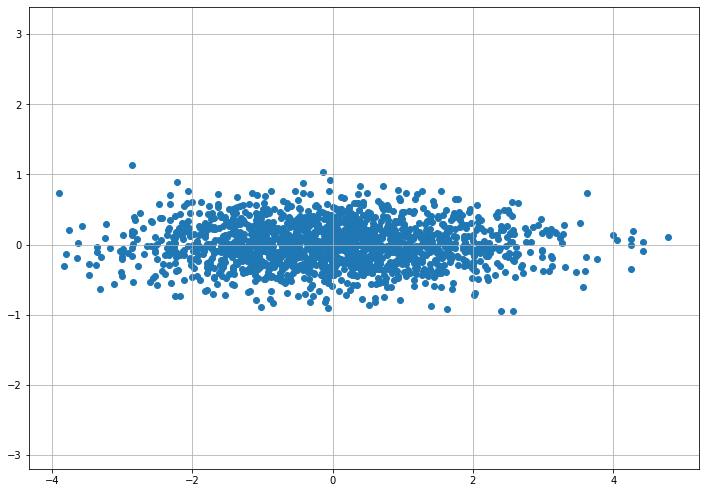

In [11]:
data_2d_zm_rot = data_2d_zm @ v.T

plt.scatter(*data_2d_zm_rot.T);
plt.grid();
plt.axis('equal');

The singular values, $\textbf{d}$ have a special relationship with the covariance matrix:  the eigenvalues of the covariance matrix are

\begin{equation}
    \textbf{e} = \frac{\textbf{d}^2}{N - 1}
\end{equation}

In [12]:
ev = d**2 / (data_2d_zm.shape[0] - 1.0)
ev

array([1.9629, 0.0974])

The eigenvalues of the covariance matrix correspond to the amount of variance captured by each right singular vector (our new basis).  They are sorted and larger values indicate dimensions that capture a larger amount of variance in the data.

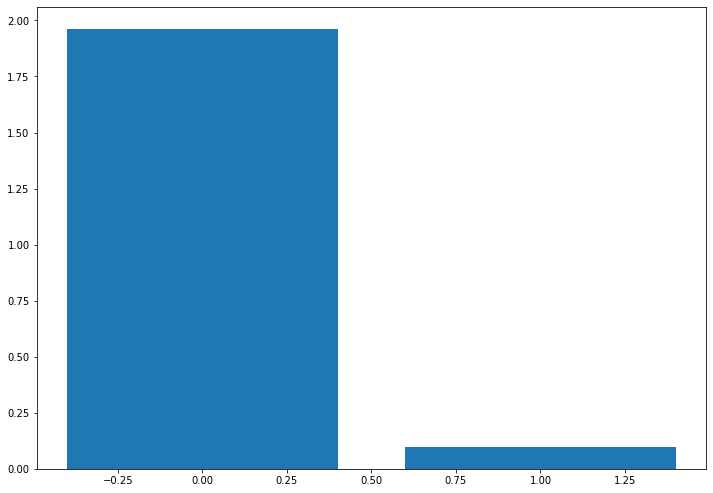

In [13]:
plt.bar(range(len(ev)), ev);

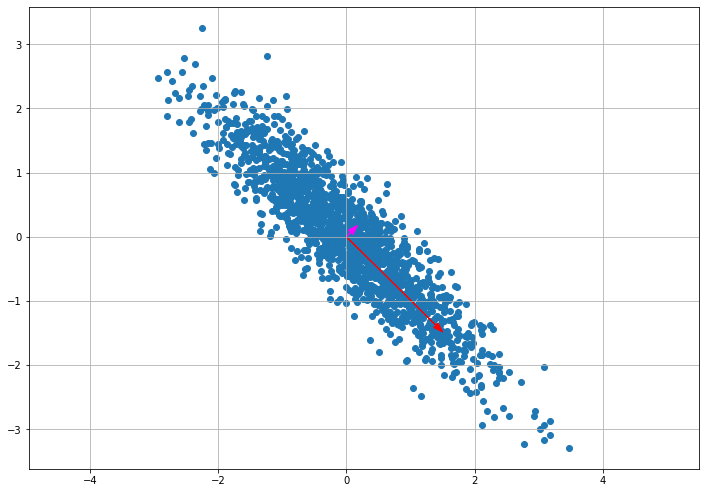

In [14]:
vcomp = v.T * ev

plt.scatter(*data_2d_zm.T);
plt.arrow(0, 0, *vcomp[:, 0], head_width=0.1, color='red');
plt.arrow(0, 0, *vcomp[:, 1], head_width=0.1, color='magenta');
plt.grid();
plt.axis('equal');

These ideas can be used to construct a "whitening matrix" that projects the data onto our new basis and where each axis has unit variance.

In [15]:
pcomp = v.T / np.sqrt(ev.T)

Note that the covariance of the data becomes one along the diagonal after being projected onto the whitening matrix.

In [16]:
proj = data_2d_zm @ pcomp
np.cov(proj.T)

array([[1.0000e+00, 1.0018e-16],
       [1.0018e-16, 1.0000e+00]])

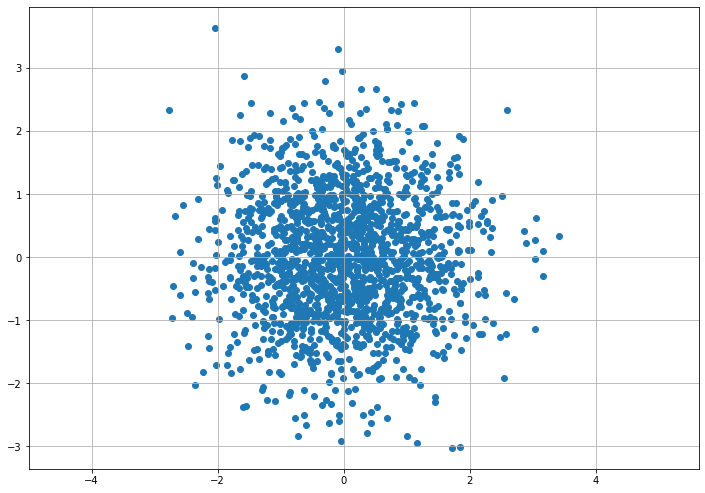

In [17]:
plt.scatter(*proj.T);
plt.grid();
plt.axis('equal');

In order to perform dimensionality reduction, we simple project the data onto the first $p$ principal components, i.e., the first few dimensions of the right singular vectors or the whitening matrix.

Principal components that do not capture much variance, can be discarded, providing reduced dimensionality.

In [18]:
proj = data_2d_zm @ pcomp

In [19]:
proj_first = proj.copy()
proj_first[:, 1] = 0.0

proj_first

array([[-0.1969,  0.    ],
       [ 0.7346,  0.    ],
       [ 0.9432,  0.    ],
       [ 0.8435,  0.    ],
       ...,
       [-0.1047,  0.    ],
       [ 2.1302,  0.    ],
       [-0.7019,  0.    ],
       [ 2.476 ,  0.    ]])

The inverse of the projection onto the whitening matrix is also easily computed and can be used to reconstruct the data from its dimensionality-reduced form.

In [20]:
w_inv = v * np.sqrt(ev)[:, None]
w_inv

array([[ 0.9959, -0.9854],
       [ 0.2195,  0.2218]])

In [21]:
recon_first = proj_first @ w_inv

Here, we see the reconstructions of our data along only the first and second principal components.

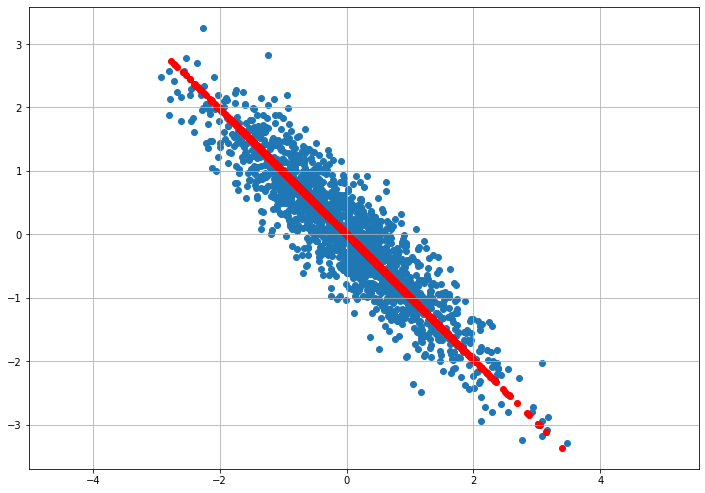

In [22]:
plt.scatter(*data_2d_zm.T);
plt.scatter(*recon_first.T, color='red');
plt.grid();
plt.axis('equal');

In [23]:
proj_second = proj.copy()
proj_second[:, 0] = 0.0

recon_second = proj_second @ w_inv

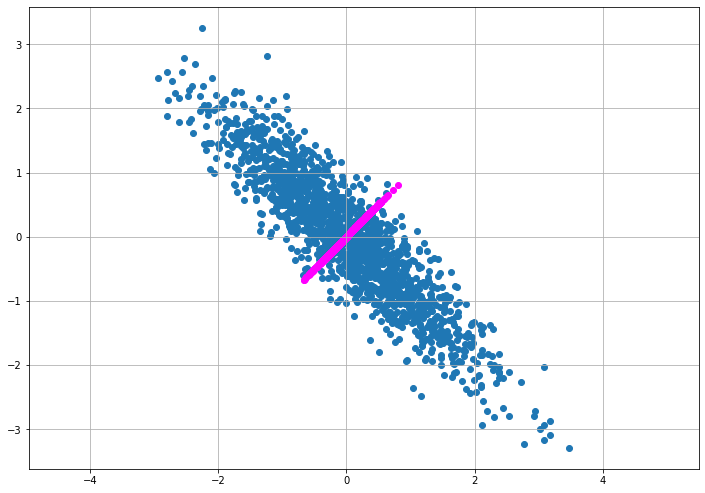

In [24]:
plt.scatter(*data_2d_zm.T);
plt.scatter(*recon_second.T, color='magenta');
plt.grid();
plt.axis('equal');

## Now with MNIST hand-written digits

Next, let's see how this all works out when working with somewhat more realistic data.  In order to explore this, we'll use the notorious MNIST hand-written digit dataset.

In [25]:
%%bash
ls ~/data/kaggle/digit-recognizer

digit-recognizer.zip
sample_submission.csv
test.csv
train.csv


In [26]:
import os

import pandas as pd
import skimage as ski

In [27]:
train_csv = pd.read_csv(os.path.expanduser('~/data/kaggle/digit-recognizer/train.csv'))
train_csv

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


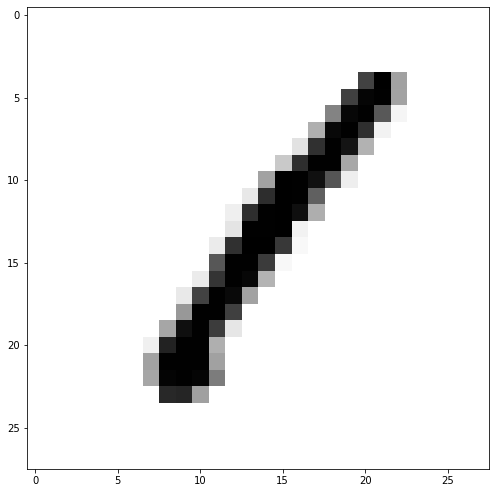

In [28]:
plt.imshow(np.array(train_csv.iloc[0, 1:]).reshape((28, 28)), cmap=plt.cm.gray_r);

In [29]:
imgs = ski.util.img_as_float(np.array(train_csv.iloc[:, 1:]).reshape((-1, 28*28)))
imgs.shape

(42000, 784)

In [30]:
def plot_montage(imgs, n=36):
    imgs = imgs[:n].reshape((-1, 28, 28))
    montage = ski.util.montage(imgs.reshape((-1, 28, 28)))
    plt.imshow(montage, cmap=plt.cm.gray_r, aspect='equal', interpolation='none');
    plt.axis('off');

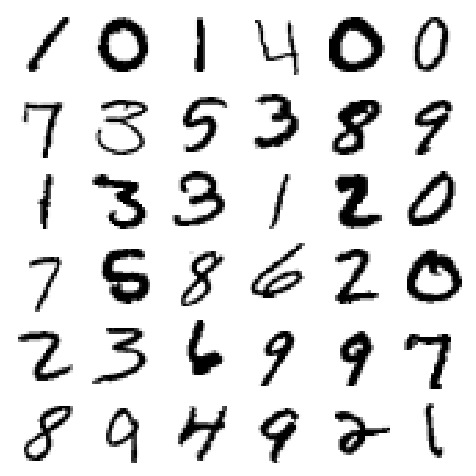

In [31]:
plot_montage(imgs);

In [32]:
img_means = imgs.mean(0)
imgs_zm = imgs - img_means
imgs.dtype, imgs_zm.dtype

(dtype('float64'), dtype('float64'))

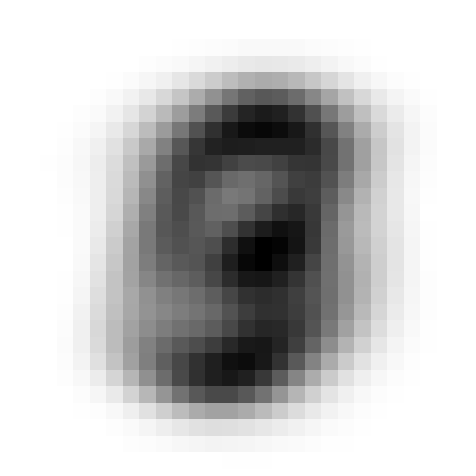

In [33]:
plt.imshow(img_means.reshape((28, 28)), cmap=plt.cm.gray_r, aspect='equal', interpolation='none');
plt.axis('off');

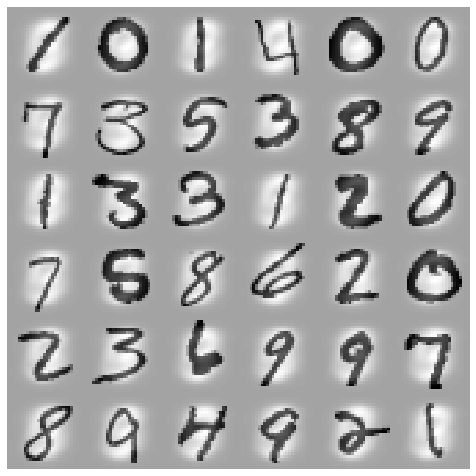

In [34]:
plot_montage(imgs_zm);

In [35]:
u, d, v = np.linalg.svd(imgs_zm, full_matrices=False)
u.shape, d.shape, v.shape

((42000, 784), (784,), (784, 784))

In [36]:
ev = d**2 / (imgs_zm.shape[0] - 1.0)
ev.shape

(784,)

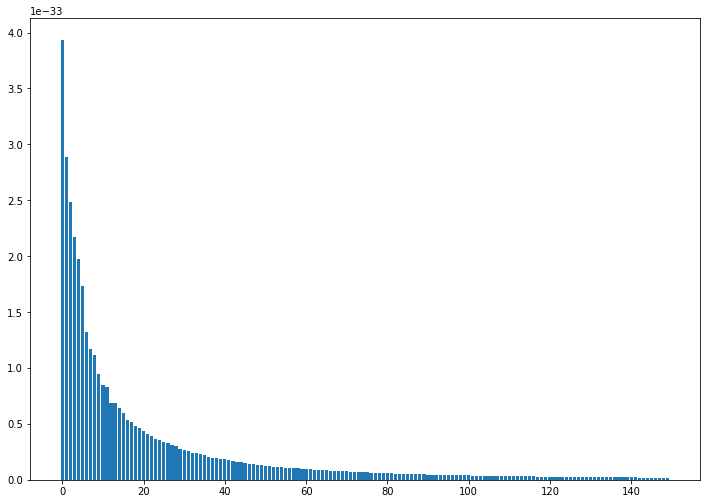

In [52]:
plt.bar(range(150), ev[:150]);

In [38]:
pcomp = v.T / np.sqrt(ev.T)
pcomp.shape

(784, 784)

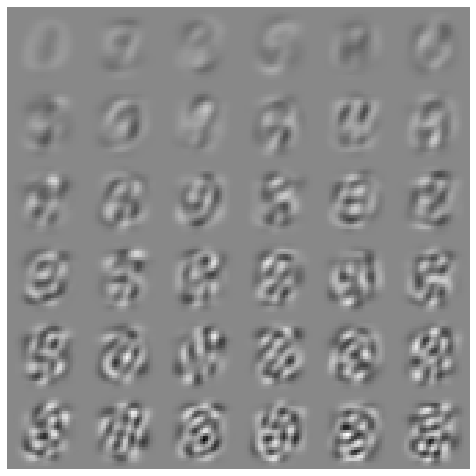

In [39]:
plot_montage(pcomp.T)

In [40]:
def proj_down(imgs, nkeep):
    return (imgs - img_means) @ pcomp[:, :nkeep]

In [41]:
w_inv = v * np.sqrt(ev)[:, None]
w_inv

array([[ 2.2457e-35,  3.4823e-33,  6.9647e-33,  6.9647e-33, ...,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 2.7697e-35,  1.1938e-32, -8.9532e-33, -2.9844e-33, ...,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [-7.8353e-36,  1.3825e-33,  4.1474e-33,  0.0000e+00, ...,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 5.5113e-36,  6.4669e-34, -1.9401e-33, -1.2934e-33, ...,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       ...,
       [ 0.0000e+00,  3.4605e-34,  2.9977e-34, -2.7161e-34, ...,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00, -3.5228e-34,  8.2882e-35, -7.7592e-35, ...,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00, -4.7106e-35, -3.6328e-35, -1.1942e-34, ...,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00, -2.1081e-35,  2.7743e-35, -3.0707e-35, ...,
         0.0000e+00,  0.0000e+00,  0.0000

In [42]:
def proj_up(proj):
    npad = w_inv.shape[0] - proj.shape[1]
    proj_pad = np.pad(proj, ((0, 0), (0, npad)))
    return proj_pad @ w_inv + img_means

In [43]:
proj = proj_down(imgs_zm, 10)
recon = proj_up(proj)

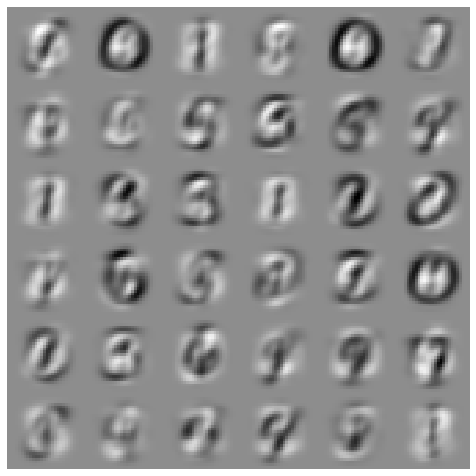

In [44]:
plot_montage(recon);

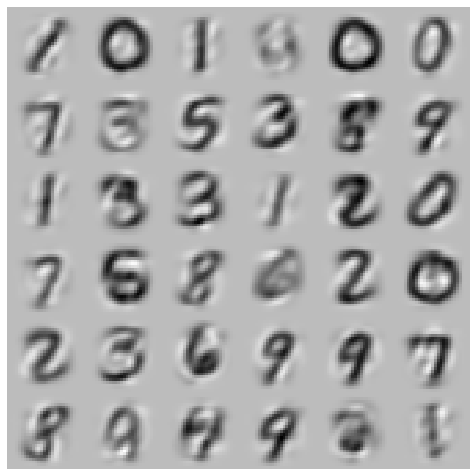

In [45]:
plot_montage(proj_up(proj_down(imgs, 20)));

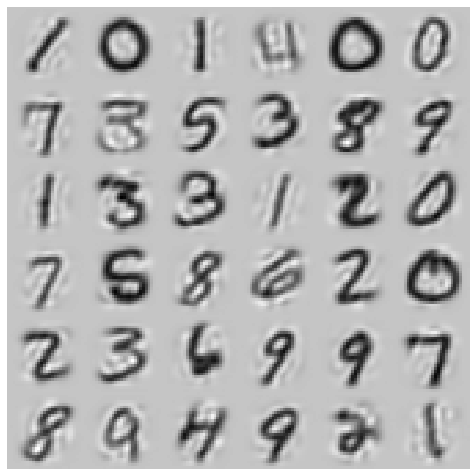

In [46]:
plot_montage(proj_up(proj_down(imgs, 50)));

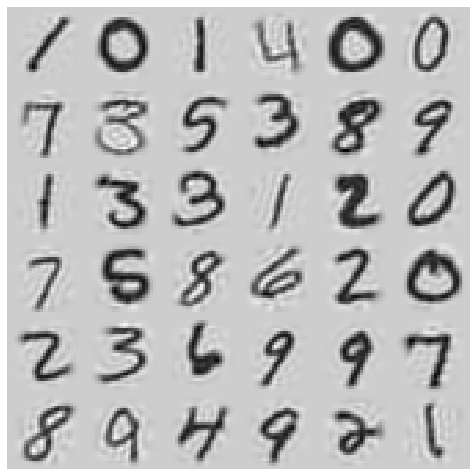

In [47]:
plot_montage(proj_up(proj_down(imgs, 100)));

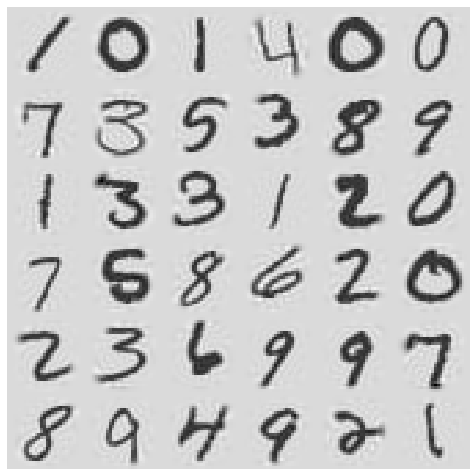

In [48]:
plot_montage(proj_up(proj_down(imgs, 200)));

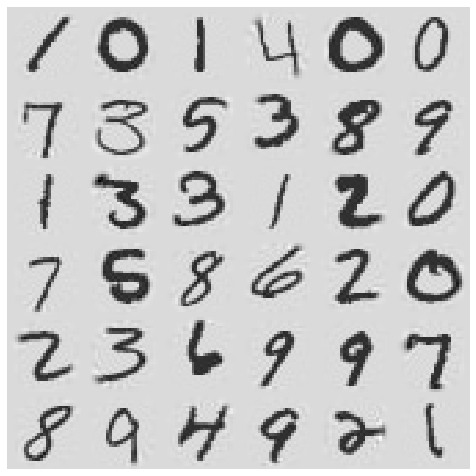

In [49]:
plot_montage(proj_up(proj_down(imgs, 300)));

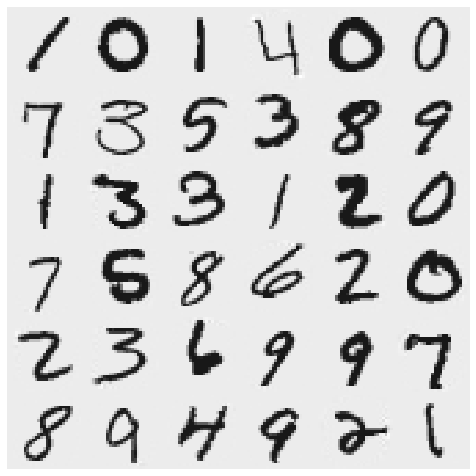

In [50]:
plot_montage(proj_up(proj_down(imgs, 500)));

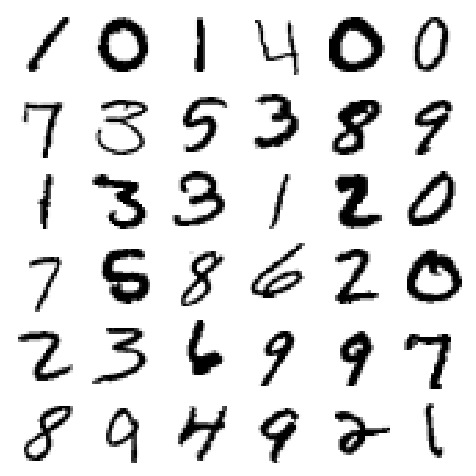

In [51]:
plot_montage(proj_up(proj_down(imgs, 700)));